In [32]:
import os
import sys
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, models

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download WordNet corpus
nltk.download('wordnet')

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'emotion-detection-from-text:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1116138%2F1874890%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T002128Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D826ee9f977a11a83061a978ad146f82930b44f1755e72739922678e181d3db3bcad4e4cf4418086ac89e3eedb74533fd1f5dd37e59a08aa2c427ee4132cde17729c243aa876454b1de4d29f75832b042e3ee4f71dd1e76066bfe2e821631ba9ff4eb0d11afe3bb674a29fac44ea60cad4bd2bfb271f88d270283d9e57402b6d3f8eccbf08f86a16efed402740d7f959de56a8baacab5c1736d691b26176d28eff43923aaa1b8b1fb760853a132b3305358f794842914180f936f8c4fff53b90b264cc858b201f8350d1b0f4acf089b03db4be96a2dd2ccb8eb4a4c62f627e24aa32570cf73099d8cc98eb2989535329dbdad37da7369300791ab54308fd586ec'

# Set the destination path where the data will be downloaded
DESTINATION_PATH = '/content/data'

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(DESTINATION_PATH, directory)
    os.makedirs(destination_path, exist_ok=True)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[===========================                       ] 901120 bytes downloaded

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[==================================================] 1634382 bytes downloaded
Downloaded and uncompressed: emotion-detection-from-text
Data source import complete.


# Read dataset

In [21]:
df = pd.read_csv(
    '/kaggle/input/emotion-detection-from-text/tweet_emotions.csv',
    usecols=['content', 'sentiment'],
    dtype={'content': 'string', 'sentiment': 'category'}
)
df.rename(columns={'content': 'sentence', 'sentiment': 'label'}, inplace=True)

df = df[ (df.label == 'happiness') | (df.label == 'sadness') ]
df.label = df.label.cat.remove_unused_categories()

label_names = df.label.cat.categories.tolist()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

print(f'{len(train_df)=}, {len(test_df)=}')
print(label_names)

len(train_df)=8299, len(test_df)=2075
['happiness', 'sadness']


# Distribution of classes

,label,sentence
23531,sadness,&quot;My problem isn't that I miss you... 'cau...
8051,sadness,That's it? It's done already? This is one proo...
11499,sadness,I am so hungry! And there is no food for me to...
31288,happiness,Feet hurt...finally in bed...will not forget t...
18561,sadness,really ill atm


,label,sentence
11535,sadness,looks like we're rained out for weekend climbing
32287,sadness,Hi Everyone miss me much? muahhhhhhhhhhhhhhhh...
17534,sadness,"rode the moped to the mall. fun stuff, its fli..."
4696,sadness,gutted!!! vodafone wont repair my faulty Samsu...
23706,happiness,"@shadowowns aww, &lt;3 why thank youu."


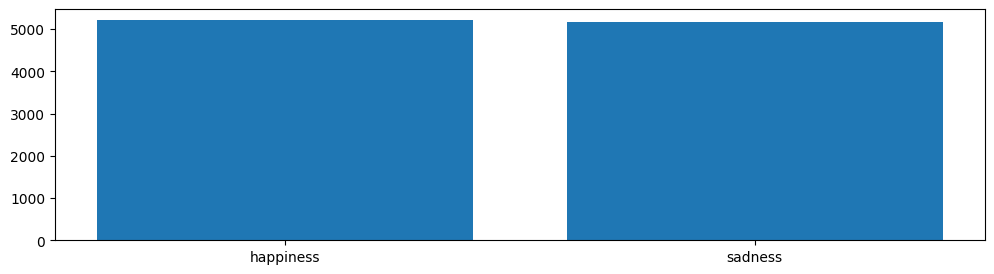

In [22]:
display(train_df.head())
display(test_df.head())

plt.figure(figsize=(12,3))
plt.bar(x=label_names, height=np.bincount(df['label'].cat.codes))

class_weights = dict(enumerate(
    compute_class_weight(
        class_weight="balanced",
        classes=pd.unique(df['label']),
        y=df['label']
    )
))

# Preprocessors

In [23]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')    # add/remove regex as required
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
NUMBERS = re.compile('\d+')

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, 'http\S+', '')
    text = tf.strings.regex_replace(text, '([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)', ' ')
    text = tf.strings.regex_replace(text, '[/(){}\[\]\|@,;]', ' ')
    text = tf.strings.regex_replace(text, '[^0-9a-z #+_]', '')
    text = tf.strings.regex_replace(text, '[\d+]', '')
    return text

def lemmatize_tokenize(text):
    # TODO: rework to use tf.strings
    # remove stopwords and lemmatize
    tokens = [word for word in text.split() if word not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

# Model

In [24]:
N_CLASSES = len(label_names)
MAX_FEATURES = 5_000
MAX_SEQ_LEN = 256
EMBEDDING_DIM = 128

vectorizer_layer = layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    standardize=clean_text,
#     split=lemmatize_tokenize,
    output_sequence_length=MAX_SEQ_LEN,
    output_mode='int'
)
vectorizer_layer.adapt(train_df.sentence)

In [25]:
model = models.Sequential([
    keras.Input(shape=(1,), dtype=tf.string),
    vectorizer_layer,
    layers.Embedding(MAX_FEATURES, EMBEDDING_DIM),

    layers.SpatialDropout1D(0.2),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='gelu'),
    layers.Dropout(0.4),
    layers.Dense(N_CLASSES, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train

In [26]:
X_train, y_train = train_df.sentence, train_df.label.cat.codes
X_test,  y_test  =  test_df.sentence,  test_df.label.cat.codes

history = model.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=300,
    verbose=1,
    class_weight=class_weights,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)],
)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/300
33/33 [==============================] - 5s 123ms/step - loss: 0.6889 - accuracy: 0.5428 - val_loss: 0.6769 - val_accuracy: 0.6858
Epoch 2/300
33/33 [==============================] - 3s 104ms/step - loss: 0.6424 - accuracy: 0.6831 - val_loss: 0.5801 - val_accuracy: 0.7513
Epoch 3/300
33/33 [==============================] - 3s 104ms/step - loss: 0.4992 - accuracy: 0.7741 - val_loss: 0.4497 - val_accuracy: 0.7947
Epoch 4/300
33/33 [==============================] - 4s 132ms/step - loss: 0.3958 - accuracy: 0.8274 - val_loss: 0.4259 - val_accuracy: 0.8019
Epoch 5/300
33/33 [==============================] - 3s 102ms/step - loss: 0.3485 - accuracy: 0.8573 - val_loss: 0.4127 - val_accuracy: 0.8082
Epoch 6/300
33/33 [==============================] - 3s 103ms/step - loss: 0.3035 - accuracy: 0.8758 - val_loss: 0.4133 - val_accuracy: 0.8135
Epoch 7/300
33/33 [==============================] - 4s 133ms/step - loss: 0.2707 - accuracy: 0.8908 - val_loss: 0.4161 - val_accuracy: 0.8173

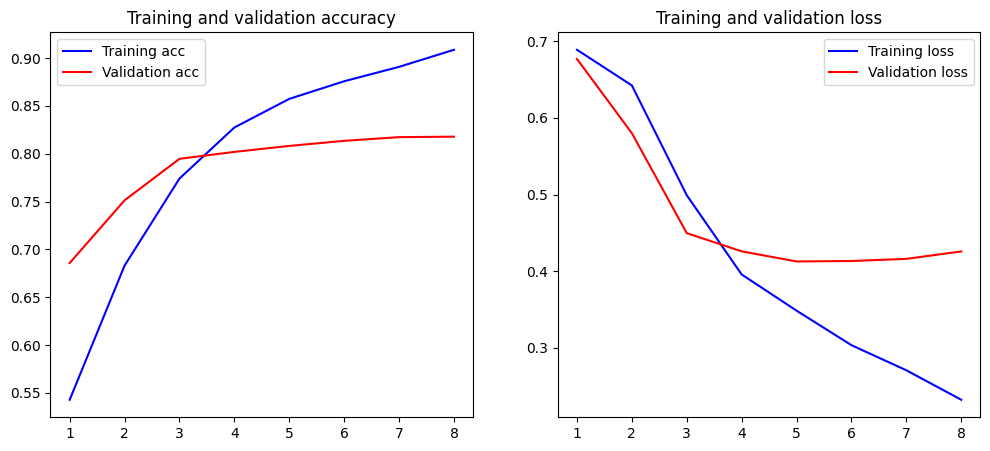

In [27]:
def plot_history(history):
    acc,  val_acc  = history['accuracy'],  history['val_accuracy']
    loss, val_loss = history['loss'], history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1)

    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy'); plt.legend(); plt.subplot(1, 2, 2)

    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss'); plt.legend(); plt.show()

plot_history(history.history)

# Evaluate

65/65 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

   happiness       0.81      0.82      0.81      1015
     sadness       0.82      0.82      0.82      1060

    accuracy                           0.82      2075
   macro avg       0.82      0.82      0.82      2075
weighted avg       0.82      0.82      0.82      2075



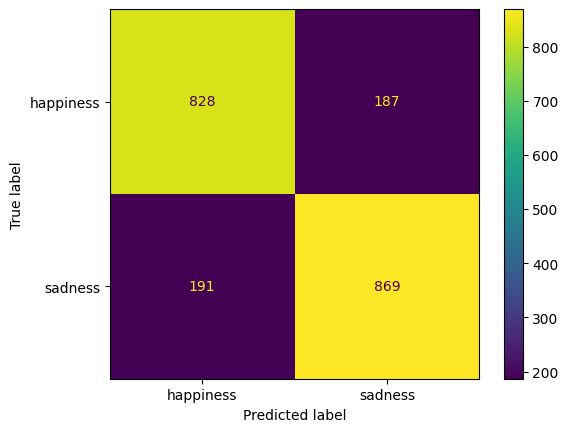

In [28]:
y_pred = model.predict(X_test).argmax(1)

print(classification_report(
    y_test, y_pred, target_names=label_names
))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=label_names
)

In [29]:
model.save('sentiment-for-nova.keras')

# Demo

In [30]:
text = [
    "I wish you didn't have to go... everything is so much brighter when you are around",
    "this is amazing, I love it",
    "I failed my driving test for the third time",
    "meet me when you get back - I love being around you",
    "My dog passed away last night"
]

preds = model.predict(pd.Series(text)).argmax(1).squeeze()
print([label_names[pred] for pred in preds])

1/1 [==============================] - 0s 23ms/step
['sadness', 'happiness', 'sadness', 'happiness', 'sadness']
